In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device selected:", device)

Device selected: cuda


In [3]:
df = pd.read_csv('IMDB Dataset.csv')

print("Shape of dataset:", df.shape)
print(df.head())

Shape of dataset: (50000, 2)
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [4]:
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

def clean_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)  
    text = re.sub(r'[^a-z\s]', '', text)  
    text = re.sub(r'\s+', ' ', text).strip()  
    return text

df['review'] = df['review'].apply(clean_text)

label_encoder = LabelEncoder()
df['sentiment'] = label_encoder.fit_transform(df['sentiment'])

X_train, X_test, y_train, y_test = train_test_split(
    df['review'], df['sentiment'], test_size=0.2, random_state=42
)

print("Examples after cleaning:")
print(X_train.iloc[0])
print("Class:", y_train.iloc[0])

Examples after cleaning:
thats what i kept asking myself during the many fights screaming matches swearing and general mayhem that permeate the minutes the comparisons also stand up when you think of the onedimensional characters who have so little depth that it is virtually impossible to care what happens to them they are just badly written cyphers for the director to hang his multicultural beliefs on a topic that has been done much better in other dramas both on tv and the cinemai must confess im not really one for spotting bad performances during a film but it must be said that nichola burley as the heroines slutty best friend and wasim zakir as the nasty bullying brother were absolutely terrible i dont know what acting school they graduated from but if i was them id apply for a full refund post haste only samina awan in the lead role manages to impress in a cast of socalled british talent that well probably never hear from again at least thats the hope next time hire a different sc

In [5]:
from collections import Counter

def tokenize(text):
    return text.split()

all_tokens = []
for review in X_train:
    all_tokens.extend(tokenize(review))

vocab_counter = Counter(all_tokens)
vocab = {word: idx+2 for idx, (word, _) in enumerate(vocab_counter.items())} 
vocab_size = len(vocab) + 2  

def encode_review(text, vocab):
    return [vocab.get(word, 1) for word in tokenize(text)] 

import torch

MAX_LEN = 200

def process_reviews(reviews, vocab, max_len=MAX_LEN):
    encoded = [torch.tensor(encode_review(review, vocab))[:max_len] for review in reviews]
    padded = []
    for seq in encoded:
        length = len(seq)
        if length < max_len:
            pad = torch.zeros(max_len - length, dtype=torch.long)
            seq = torch.cat([seq, pad])
        else:
            seq = seq[:max_len]
        padded.append(seq)
    padded_tensor = torch.stack(padded)
    return padded_tensor

X_train_seq = process_reviews(X_train, vocab, MAX_LEN)
X_test_seq = process_reviews(X_test, vocab, MAX_LEN)

y_train_tensor = torch.tensor(np.array(y_train)).long()
y_test_tensor = torch.tensor(np.array(y_test)).long()

print("Vocabulary size:", vocab_size)
print("Padded example review (tensor):", X_train_seq[0])

Vocabulary size: 186360
Padded example review (tensor): tensor([  2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,
         16,  17,  18,  19,   9,  20,   9,  21,  22,  23,  24,  25,  26,  27,
         28,   9,  29,  30,  31,  32,  33,  34,  35,  18,  36,  37,  38,  39,
         40,  41,   3,  42,  40,  43,  44,  45,  46,  47,  48,  49,  50,   9,
         51,  40,  52,  53,  54,  55,  56,  57,  58,  18,  59,  60,  61,  62,
         63,  64,  65,  66,  67,  56,  68,  15,   9,  69,  70,  71,  72,  73,
         74,  75,  50,  76,  77,  78,   8,  57,  79,  80,  36,  70,  81,  82,
         18,  83,  84,  85,   9,  86,  87,  88,  89,  15,  90,  91,  85,   9,
         92,  93,  94,  95,  96,  97,   4,  98,  99,   3, 100, 101,  44, 102,
        103,  80, 104,   4, 105,  43, 106, 107,  50,  57, 108, 109, 110, 111,
        112, 113, 114,  64,   9, 115, 116, 117,  40, 118,  64,  57, 119,  28,
        120, 121, 122,  18, 123, 124, 125, 126, 103, 127, 128, 129,   2,   9,
        

In [6]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes=2, num_layers=1):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.embedding(x)
        out, (hn, cn) = self.lstm(x)
        out = out[:, -1, :]
        out = self.dropout(out)
        logits = self.fc(out)
        return logits

EMBED_DIM = 128
HIDDEN_DIM = 128
NUM_LAYERS = 1
NUM_CLASSES = 2

model = LSTMClassifier(vocab_size=vocab_size, embed_dim=EMBED_DIM,
                       hidden_dim=HIDDEN_DIM, num_classes=NUM_CLASSES,
                       num_layers=NUM_LAYERS).to(device)

print(model)


LSTMClassifier(
  (embedding): Embedding(186360, 128, padding_idx=0)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [7]:
from torch.utils.data import TensorDataset, DataLoader

BATCH_SIZE = 128

train_data = TensorDataset(X_train_seq, y_train_tensor)
test_data = TensorDataset(X_test_seq, y_test_tensor)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Train loader batches:", len(train_loader))
print("Test loader batches:", len(test_loader))

Train loader batches: 313
Test loader batches: 79


In [8]:
model.train()
for batch_idx, (inputs, targets) in enumerate(train_loader):
    inputs, targets = inputs.to(device), targets.to(device)

    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    loss.backward()
    optimizer.step()

    if (batch_idx + 1) % 50 == 0:
        print(f"Batch {batch_idx+1}/{len(train_loader)} - Loss: {loss.item():.4f}")

Batch 50/313 - Loss: 0.6966
Batch 100/313 - Loss: 0.6852
Batch 150/313 - Loss: 0.7119
Batch 200/313 - Loss: 0.6821
Batch 250/313 - Loss: 0.6904
Batch 300/313 - Loss: 0.6976


In [9]:
NUM_EPOCHS = 10

for epoch in range(NUM_EPOCHS):
    model.train()
    epoch_loss = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} - Average Loss: {avg_loss:.4f}")

print("Training complete!")


Epoch 1/10 - Average Loss: 0.6846
Epoch 2/10 - Average Loss: 0.6874
Epoch 3/10 - Average Loss: 0.6850
Epoch 4/10 - Average Loss: 0.6701
Epoch 5/10 - Average Loss: 0.6396
Epoch 6/10 - Average Loss: 0.6564
Epoch 7/10 - Average Loss: 0.6729
Epoch 8/10 - Average Loss: 0.5967
Epoch 9/10 - Average Loss: 0.4320
Epoch 10/10 - Average Loss: 0.3880
Training complete!


In [10]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

accuracy = correct / total
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.7816


In [13]:
def predict_sentiment(review, model, vocab, max_len=200):
    model.eval()
    review_clean = clean_text(review)
    encoded = encode_review(review_clean, vocab)
    length = len(encoded)
    if length < max_len:
        encoded += [0] * (max_len - length)
    else:
        encoded = encoded[:max_len]
    tensor_review = torch.tensor(encoded, dtype=torch.long).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(tensor_review)
        probs = torch.softmax(output, dim=1).cpu().numpy()[0]
        pred_class = np.argmax(probs)
    sentiment = label_encoder.inverse_transform([pred_class])[0]
    return sentiment

reviews = [
    "An absolute masterpiece with strong performances and a gripping story.",
    "It was decent, but not as good as I expected.",
    "I loved the cinematography and music!",
    "The plot was too slow and boring for my taste."
]

for r in reviews:
    print("Review:", r)
    print("Predicted sentiment:", predict_sentiment(r, model, vocab))
    print("-" * 40)

Review: An absolute masterpiece with strong performances and a gripping story.
Predicted sentiment: positive
----------------------------------------
Review: It was decent, but not as good as I expected.
Predicted sentiment: positive
----------------------------------------
Review: I loved the cinematography and music!
Predicted sentiment: positive
----------------------------------------
Review: The plot was too slow and boring for my taste.
Predicted sentiment: negative
----------------------------------------


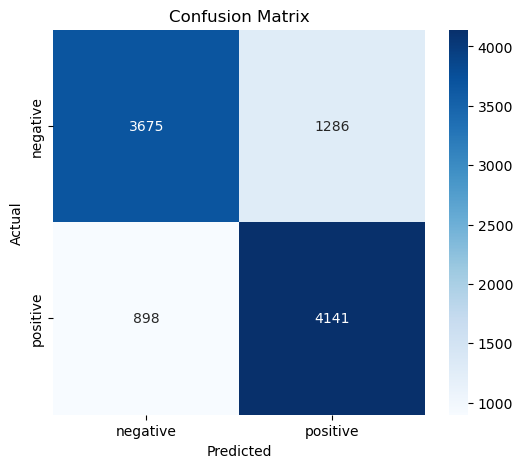

              precision    recall  f1-score   support

    negative       0.80      0.74      0.77      4961
    positive       0.76      0.82      0.79      5039

    accuracy                           0.78     10000
   macro avg       0.78      0.78      0.78     10000
weighted avg       0.78      0.78      0.78     10000



In [14]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_targets.extend(targets.cpu().numpy())

cm = confusion_matrix(all_targets, all_preds)
report = classification_report(all_targets, all_preds, target_names=label_encoder.classes_)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(report)


In [15]:
# Step 13: Save model and artifacts using joblib, and create a simple app.py (Gradio UI)

import joblib

# Save vocab and label encoder using joblib
joblib.dump(vocab, "vocab.joblib")
joblib.dump(label_encoder, "label_encoder.joblib")

# Save model weights (standard for PyTorch)
torch.save(model.state_dict(), "lstm_model.pt")
